# Exercise 3 - Visual Features and RANSAC

In this exercise, you will implement a visual feature detector and descriptor to find correspondences/matches between two images together. You will then use these matches to stich these images together within a RANSAC routine to deal with outliers.


## 3.1 Implement a feature detector [5.0]

Your goal is to implement a feature detector as explained in the lecture. Implement both the Harris-Corner detector and Shi-Tomasi corner criteria  in the function. Implement the ``compute_corners`` function. It takes as input:

    I : float [MxN] 
        grayscale image

    type :  string
            corner type ('harris' or 'Shi-Tomasi')

    T:  float
        threshold for corner detection
    
and returns:

    corners : numpy array [num_corners x 2] 
              Coordinates (x,y) of the detected corners.    

Test your implementation on the 'checkerboard.jpg' image and verify that the detections are correct.

** Hints **: 

1. You may use 'ndimage.convolve' function from the scipy library to perform 2D convolution.

Text(0.5, 0, 'Shi-Tomasi Corners')

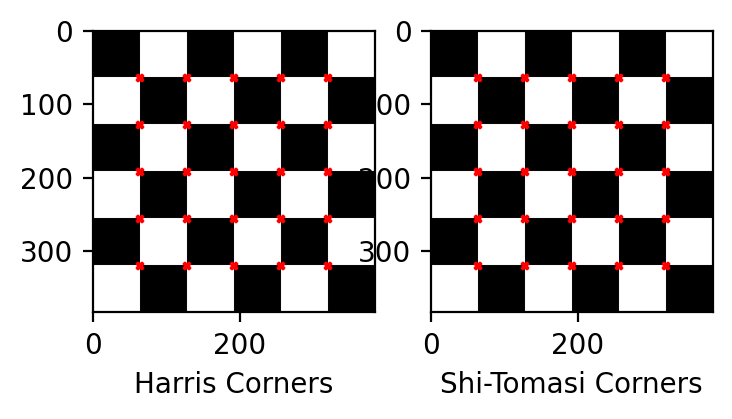

In [9]:
import numpy as np
import cv2
import imageio
import matplotlib.pyplot as plt
import ex3 as ex
from skimage.color import rgb2gray

%matplotlib inline

fig = plt.figure(figsize=(4, 4), dpi=200)

# Read images and transform them to grayscale
I_checkerboard = imageio.imread('checkerboard.png')
# I_checkerboard = rgb2gray(I_checkerboard)

# Compute corners and visualize them on top of the image
T_harris = 0.8  # TODO:  Choose a suitable threshold
T_shi_tomasi = 0.6 # TODO:  Choose a suitable threshold
corners_harris, _ = ex.compute_corners(I_checkerboard, 'harris', T_harris)
corners_shi_tomasi, _ = ex.compute_corners(I_checkerboard, 'shi-tomasi', T_shi_tomasi)

# Visualize the detections by plotting them over the image
plt.subplot(1,2,1)
plt.imshow(I_checkerboard, cmap='gray')
plt.plot(corners_harris[:,0], corners_harris[:,1], 'rx', markersize=2)
plt.xlabel("Harris Corners")

plt.subplot(1,2,2)
plt.imshow(I_checkerboard, cmap='gray')
plt.plot(corners_shi_tomasi[:,0], corners_shi_tomasi[:,1], 'rx', markersize=2)
plt.xlabel("Shi-Tomasi Corners")


## 3.2 Compute a feature descriptor [5.0]

The next task is to implement a feature descriptor as explained in the lecture. The descriptor for each keyppoint should 128 bits. Implement the ``compute_descriptors`` function. It takes as input:

    I : float [MxN]
        grayscale image as a 2D numpy array
    corners : numpy array [num_corners x 2] 
              Coordinates of the detected corners. 
    
and returns:

    D : numpy array [num_corners x 128]
        128 bit descriptors  corresponding to each corner keypoint

Test your implementation on the 'checkerboard.jpg' image.

** Hints **: 

1. You may use think of re-using the gradient information from ``compute_corners`` for computing descriptors.

In [ ]:
# read images and transform them to grayscale
I1 = imageio.imread('mountain_1.jpg')
I1_gray = cv2.cvtColor(I1, cv2.COLOR_RGB2GRAY)

I2 = imageio.imread('mountain_2.jpg')
I2_gray = cv2.cvtColor(I2, cv2.COLOR_RGB2GRAY)

# compute corner keypoints
C1_harris =  ex.compute_corners(I1_gray, 'harris', T_harris)
C2_harris =  ex.compute_corners(I2_gray, 'harris', T_harris)

C1_shi_tomasi =  ex.compute_corners(I1_gray, 'shi-tomasi', T_harris)
C2_shi_tomasi =  ex.compute_corners(I2_gray, 'shi-tomasi', T_harris)

# compute the descriptor for the two images 
D1_harris = ex.compute_descriptors(I1_gray, C1_harris)
D2_harris = ex.compute_descriptors(I2_gray, C2_harris)

D1_shi_tomasi = ex.compute_descriptors(I1_gray, C1_shi_tomasi)
D2_shi_tomasi = ex.compute_descriptors(I2_gray, C2_shi_tomasi)

C1 = np.array([[10, 10], [50, 50], [100, 100]])
C2 = np.array([[10, 10], [50, 50], [100, 100]])
M = np.array([[0,0],[1,1],[2,2]])

## 3.3 Compute correspondences for the images [5.0]

Now, the goal is to compute correspondences (matches) between two images based on the descriptors computed in the previous task. The descriptors can be compared by computing a score in a one vs all fashion, and a match should be accepted if it meets the Lowe's critera as described in the lecture. 

Implement the function `compute_matches`. It takes as input:
    
    D1 : numpy array [num_corners x 128]
         descriptors for image 1 keypoints
    
    D2 : numpy array [num_corners x 128]
         descriptors for image 2 keypoints

and returns

    M : numpy array [num_matches x 2]
        [cornerIdx1, cornerIdx2] each row contains indices of corresponding keypoints from each image.

Test your implementation on the images used in the previous task and visualize the matches. 

In [ ]:
# Matches for harris corner keypoints and corresponding keypoints
M_harris = ex.compute_matches(D1, D2)

# Matches for Shi-Tomasi keypoints and corresponding keypoints
M_shi_tomasi = ex.compute_matches(D1, D2)

# Visualize the matches
plt.figure()
ex.plot_matches(I1_gray, I2_gray, C1_harris, C2_harris, M_harris)

plt.figure()
ex.plot_matches(I1_gray, I2_gray, C1_shi_tomasi, C2_shi_tomasi, M_shi_tomasi)

## 3.4 Application: Image Stiching [5.0]

In this part of the assignment, the goal is to stitch two images (which we have used in the previous tasks) together. To stitch these images, we first need to compute a transformation (also called as Homography) between these two images. We will use the matches computed in the previous step to compute the homography.

The matches computed by matching the descriptors usually contain outliers which are bad correspondences. In this task, we want to estimate the transformation (Homography) between the two image despite the presence of outliers in th matches. In order to achieve this, you have to implement a RANSAC based algorithm which estimates the homography and the set of inlier matches. 

In order to implement the algorithm, you will need to: 
  - For each iteration, randomly choose four feature matches in all found matches in function **compute_homography_ransac()**;
  - Estimate a homography using 4 corresponding points in two images in function **comute_homography_four_matches(). This function has already been implemented for you. 
  - Calculate the geometric distance (error) betweeen the transformed points from first image and the corresponding points in the second image, namely residuals, in function **compute_residual()**;
  - Check all matches with estimated homography matrix and label inliers based on the 'max_inlier_thres' in function **compute_homography_ransac()**;
  - Terminate the procedure if a homography is found which satisfies the inliers codition or exceeds the maximum number iterations the in function **compute_homography_ransac()**.

Refer to the lecture slides for all the details.  After you have implemented all the above, you should have an good estimated homography matrix.

In [ ]:
# TODO: Estimate Homography matrix and set of inlier matches and visualize the inlier matches.


## 3.5 Application: Image stiching [5.0]

Use the estimated homography matrix to stitch and plot two images in one figure.

**Hint:** The **warpPerspective** functions of **OpenCV** library can be useful in this task.

## Image Source:
"Github: daeyun Image-Stitching Test Images", 2016. [Online]. Available: https://github.com/daeyun/Image-Stitching/tree/master/img/hill.